In [2]:
# Importing all libraries.
from pylab import *
from netCDF4 import Dataset
%matplotlib inline
import os
import cmocean as cm
from trackeddy.tracking import *
from trackeddy.datastruct import *
from trackeddy.geometryfunc import *
from trackeddy.init import *
from trackeddy.physics import *
from trackeddy.plotfunc import *
from calendar import monthrange

In [40]:
arc = pi/1.55
R = np.arange(0,arc*np.pi, 0.1)
x = 1.5*np.cos(R) + 2 + 0.1*np.random.rand(len(R))
y = np.sin(R) + 1. + 0.1*np.random.rand(len(R))

In [41]:
e,s,r=fit_ellipse(x,y,[False])

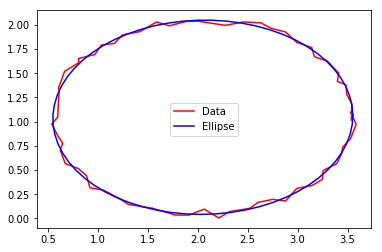

In [48]:
plot(x,y,'-r',label='Data')
plot(e['ellipse'][0],e['ellipse'][1],'-b',label='Ellipse')
legend()

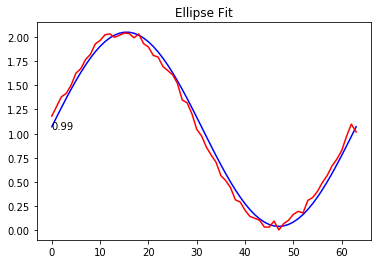

66.95075357005526 66.88954763957432


(0.9904351754789313, True)

In [49]:
ellipsefit(y,e['ellipse'][1],0.85,[True])

In [ ]:
year='1993'
monthsin=1
monthsend=3

In [ ]:
print('Analizing the year ',year,'in the months[',monthsin,'-',monthsend,']')
inputfiles='/g/data/ua8/CMEMS_SeaLevel/v3-0/'+year+'/'

outfile='/g/data/v45/jm5970/trackeddy_out/'

ii=0

datashapetime=0
for month in range(monthsin,monthsend):
    datashapetime=datashapetime+monthrange(int(year), month)[1]

ncfile=Dataset(inputfiles+'dt_global_allsat_phy_l4_'+year+'0101_20170110.nc')
ssha=squeeze(ncfile.variables['sla'][:])*100
lon=ncfile.variables['longitude'][:]
lat=ncfile.variables['latitude'][:]

sshatime=zeros([datashapetime,shape(ssha)[0],shape(ssha)[1]])
ii=0
print('Start loading data')
for month in range(monthsin,monthsend):
    daysmonth=monthrange(int(year), month)[1]
    for days in range(1,daysmonth+1):
        ncfile=Dataset(inputfiles+'dt_global_allsat_phy_l4_'+year+'%02d'%month+'%02d'%days+'_20170110.nc')
        sshatime[ii,:,:]=squeeze(ncfile.variables['sla'][:])*100        
        ii=ii+1
ssha=ma.masked_where(sshatime <= -2147483647, sshatime)
del sshatime
print('End loading data')

In [ ]:
#Area in indexes, probably in the future it will be added an option for lon - lat coords.
nofilterdata = ssha[0,:,:]
nofilterdata = nofilterdata.filled(fill_value=0)
nofilterdata = nofilterdata - ndimage.uniform_filter(nofilterdata, size=50)
#data = ma.masked_array(nofilterdata, mask)
basemap_mplot(lon,lat,[ssha[0,:,:],ssha[0,:,:]-nofilterdata,nofilterdata],title=["Field","Uniform filter (n=50)","Result"]\
              ,projection='mbtfpq',lat_0=-90,lon_0=-180,scale='Lin',cmap=cm.cm.balance\
              ,vmin=-50,vmax=50,xan=3,yan=1,figsize=(13,5),fontsize=15,dpi=300)

In [ ]:

fig,im,ax = basemap_mplot(lon,lat,nofilterdata,title="Identified eddies",projection='mbtfpq',
              lat_0=-90,lon_0=-180,scale='Lin',cmap=cm.cm.balance,\
              vmin=-50,vmax=50,xan=1,yan=1,figsize=(20,10),fontsize=20);
clb = plt.colorbar()
clb.ax.set_title('cm')

map = Basemap(projection='mbtfpq',lat_0=-90,lon_0=-180,boundinglat=-30,resolution='c')

for key,item in eddytd.items():
    x,y=map(item['position_eddy'][0],item['position_eddy'][1])
    ax.plot(x,y,'*m')
ax.plot(x,y,'*m',label='Positive eddies')
for key,item in eddytdn.items():
    x,y=map(item['position_eddy'][0],item['position_eddy'][1])
    ax.plot(x,y,'*g')
ax.plot(x,y,'*g',label='Negative eddies')
legend(loc=3)

In [ ]:
nofilterdata = ma.masked_array(ssha[0,:,:]-np.nanmean(np.squeeze(ssha[0,:,:]),axis=0))
basemap_mplot(lon,lat,[ssha[0,:,:],ssha[0,:,:]-nofilterdata,nofilterdata],title=["Field","Meridional Filter","Result"]\
              ,projection='mbtfpq',lat_0=-90,lon_0=-180,scale='Lin',cmap=cm.cm.balance\
              ,vmin=-50,vmax=50,xan=3,yan=1,figsize=(13,5),fontsize=15,dpi=300)

In [ ]:
nofilterdata = ma.masked_array((ssha[0,:,:].T-np.nanmean(np.squeeze(ssha[0,:,:]),axis=1)).T)
basemap_mplot(lon,lat,[ssha[0,:,:],ssha[0,:,:]-nofilterdata,nofilterdata],title=["Field","Zonal Filter","Result"]\
              ,projection='mbtfpq',lat_0=-90,lon_0=-180,scale='Lin',cmap=cm.cm.balance\
              ,vmin=-50,vmax=50,xan=3,yan=1,figsize=(13,5),fontsize=15,dpi=300)

In [ ]:
import itertools

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection, PolyCollection
import numpy as np

import cartopy.feature
from cartopy.mpl.patch import geos_to_path
import cartopy.crs as ccrs


fig = plt.figure(figsize=(12,8))
ax = Axes3D(fig, xlim=[-180, 180], ylim=[-90, 90])

cset = ax.contourf(Lon-180,Lat,nofilterdata, cmap=cm.cm.balance,levels=range(-60,60,10))
ax.clabel(cset, fontsize=9, inline=1)


concat = lambda iterable: list(itertools.chain.from_iterable(iterable))

target_projection = ccrs.PlateCarree(central_longitude=180)

feature = cartopy.feature.NaturalEarthFeature('physical', 'land', '110m')
geoms = feature.geometries()

geoms = [target_projection.project_geometry(geom, feature.crs)
         for geom in geoms]

paths = concat(geos_to_path(geom) for geom in geoms)

polys = concat(path.to_polygons() for path in paths)

lc = PolyCollection(polys, edgecolor='black',
                    facecolor='k', closed=False)

ax.add_collection3d(lc)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Height')

plt.axis('off')

ax.view_init(elev=90, azim=-90)

In [ ]:
import itertools

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection, PolyCollection
import numpy as np

import cartopy.feature
from cartopy.mpl.patch import geos_to_path
import cartopy.crs as ccrs



fig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(1, 2)

ax = plt.subplot(gs[0,0])
ax = Axes3D(fig, xlim=[-180, 180], ylim=[-90, 90])


cset = ax.contourf(Lon-180,Lat,nofilterdata, cmap=cm.cm.balance,levels=range(-60,60,10),vmin=-60,vmax=60)
ax.clabel(cset, fontsize=9, inline=1)

concat = lambda iterable: list(itertools.chain.from_iterable(iterable))

target_projection = ccrs.PlateCarree(central_longitude=180)

feature = cartopy.feature.NaturalEarthFeature('physical', 'land', '110m')
geoms = feature.geometries()

geoms = [target_projection.project_geometry(geom, feature.crs)
         for geom in geoms]

paths = concat(geos_to_path(geom) for geom in geoms)

polys = concat(path.to_polygons() for path in paths)

lc = PolyCollection(polys, edgecolor='black',
                    facecolor='k', closed=False)

ax.add_collection3d(lc)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Height')
#plt.axis('off')

ax.view_init(elev=0, azim=-90)

In [ ]:
basemap_mplot(lon,lat,ssha[0,:,:]*0,title="",projection='mbtfpq',lat_0=-90,lon_0=-180,\
              resolution='c',scale='Lin',vmin='',vmax='',cmap=cm.cm.balance,xan=1,yan=1,\
              figsize=(20,10),fontsize=15)
map = Basemap(projection='mbtfpq',lat_0=-90,lon_0=-180,boundinglat=-30,resolution='c')
Lon,Lat=meshgrid(lon,lat)
lonm,latm=map(Lon,Lat)
contourf(lonm,latm,ssha[0,:,:],levels=[-20,-19,19,20],cmap=plt.cm.bwr)
colorbar()

In [ ]:
CS = plt.pcolormesh(X, Y, Z,cmap=cm.cm.balance,vmin=-3,vmax=3)
CS = plt.contour(X, Y, Z,levels=[-1,0,1],vmin=-3,vmax=3)
plt.plot(CS.allsegs[0][0][0][0],CS.allsegs[0][0][0][1],'og',label='Initial coordinates')
plt.plot(CS.allsegs[0][0][-1][0],CS.allsegs[0][0][-1][1],'.m',label='Final coordinates')
plt.plot(CS.allsegs[1][0][0][0],CS.allsegs[1][0][0][1],'og')
plt.plot(CS.allsegs[1][0][-1][0],CS.allsegs[1][0][-1][1],'.m')
plt.plot(CS.allsegs[2][0][0][0],CS.allsegs[2][0][0][1],'og')
plt.plot(CS.allsegs[2][0][-1][0],CS.allsegs[2][0][-1][1],'.m')
plt.plot(CS.allsegs[3][0][0][0],CS.allsegs[3][0][0][1],'og')
plt.plot(CS.allsegs[3][0][-1][0],CS.allsegs[3][0][-1][1],'.m')

plt.title('Close contour')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim((-3.1,3.1))
plt.ylim((-1.8,1.8))
plt.legend(loc=3)
plt.show()

In [1]:
import sys
from netCDF4 import Dataset
import os
import cmocean as cm
from trackeddy.tracking import *
from trackeddy.datastruct import *
from trackeddy.geometryfunc import *
from trackeddy.init import *
from trackeddy.physics import *
#from trackeddy.plotfunc import *
from numpy import *
from pylab import *
import cmocean as cm
import random
%matplotlib inline
import scipy.optimize as opt

In [296]:
def makeGaussian(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

def moveGaussian(size,fwhm,center,timestep):
    z=zeros([timestep,size,size])
    for tt in range(0,timestep):
        z[tt,:,:]=makeGaussian(size, fwhm, (center[tt,0],center[tt,1]))
    return z

In [593]:
x,y=linspace(-10,10,50),linspace(-10,10,50)
X,Y=meshgrid(x,y)
# Gaussian:
gaussian=twoD_Gaussian((X,Y,1,0,0),  2.5, 5, 0, 0, 0 , 0)
zz=gaussian.reshape(50,50)
# Checking fitting:
gausssianfitp,R2=fit2Dcurve(zz,(x,y,zz.max(),0,0),0,initial_guess=(1,1,0,0,0,0),\
                                date='',diagnostics=False)
gaussianfit=twoD_Gaussian((X,Y,1,0,0),*gausssianfitp)

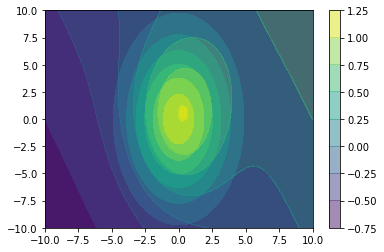

In [594]:
contourf(x,y,zz[:,:])
contourf(x,y,zz+0.05*X+0.02*Y,alpha=0.5)
colorbar()
figure()

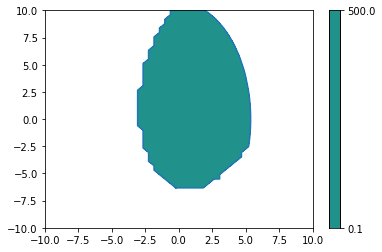

In [598]:
zz[zz+0.05*X + 0.02*Y <= 0.3]=np.nan
zzmask=ma.masked_where(isnan(zz), zz)
cs=contourf(x,y,zz,levels=[0.1,500])
colorbar()
plot(cs.allsegs[0][0][:,0],cs.allsegs[0][0][:,1])

(False,
 {'True': {'0': {'x': 24, 'y': 9},
   '1': {'x': 25, 'y': 9},
   '2': {'x': 26, 'y': 9},
   '3': {'x': 27, 'y': 9},
   '4': {'x': 28, 'y': 9},
   '5': {'x': 29, 'y': 9},
   '6': {'x': 30, 'y': 10},
   '7': {'x': 31, 'y': 11},
   '8': {'x': 32, 'y': 11},
   '9': {'x': 33, 'y': 13},
   '10': {'x': 34, 'y': 14},
   '11': {'x': 35, 'y': 15},
   '12': {'x': 36, 'y': 16},
   '13': {'x': 37, 'y': 18},
   '14': {'x': 37, 'y': 18},
   '15': {'x': 23, 'y': 49},
   '16': {'x': 23, 'y': 48},
   '17': {'x': 22, 'y': 47},
   '18': {'x': 22, 'y': 46},
   '19': {'x': 21, 'y': 45},
   '20': {'x': 21, 'y': 44},
   '21': {'x': 20, 'y': 43},
   '22': {'x': 20, 'y': 42},
   '23': {'x': 20, 'y': 41},
   '24': {'x': 19, 'y': 40},
   '25': {'x': 19, 'y': 39},
   '26': {'x': 19, 'y': 38},
   '27': {'x': 18, 'y': 37},
   '28': {'x': 18, 'y': 36},
   '29': {'x': 18, 'y': 35},
   '30': {'x': 18, 'y': 34},
   '31': {'x': 18, 'y': 33},
   '32': {'x': 18, 'y': 32},
   '33': {'x': 17, 'y': 31},
   '34': {'x':

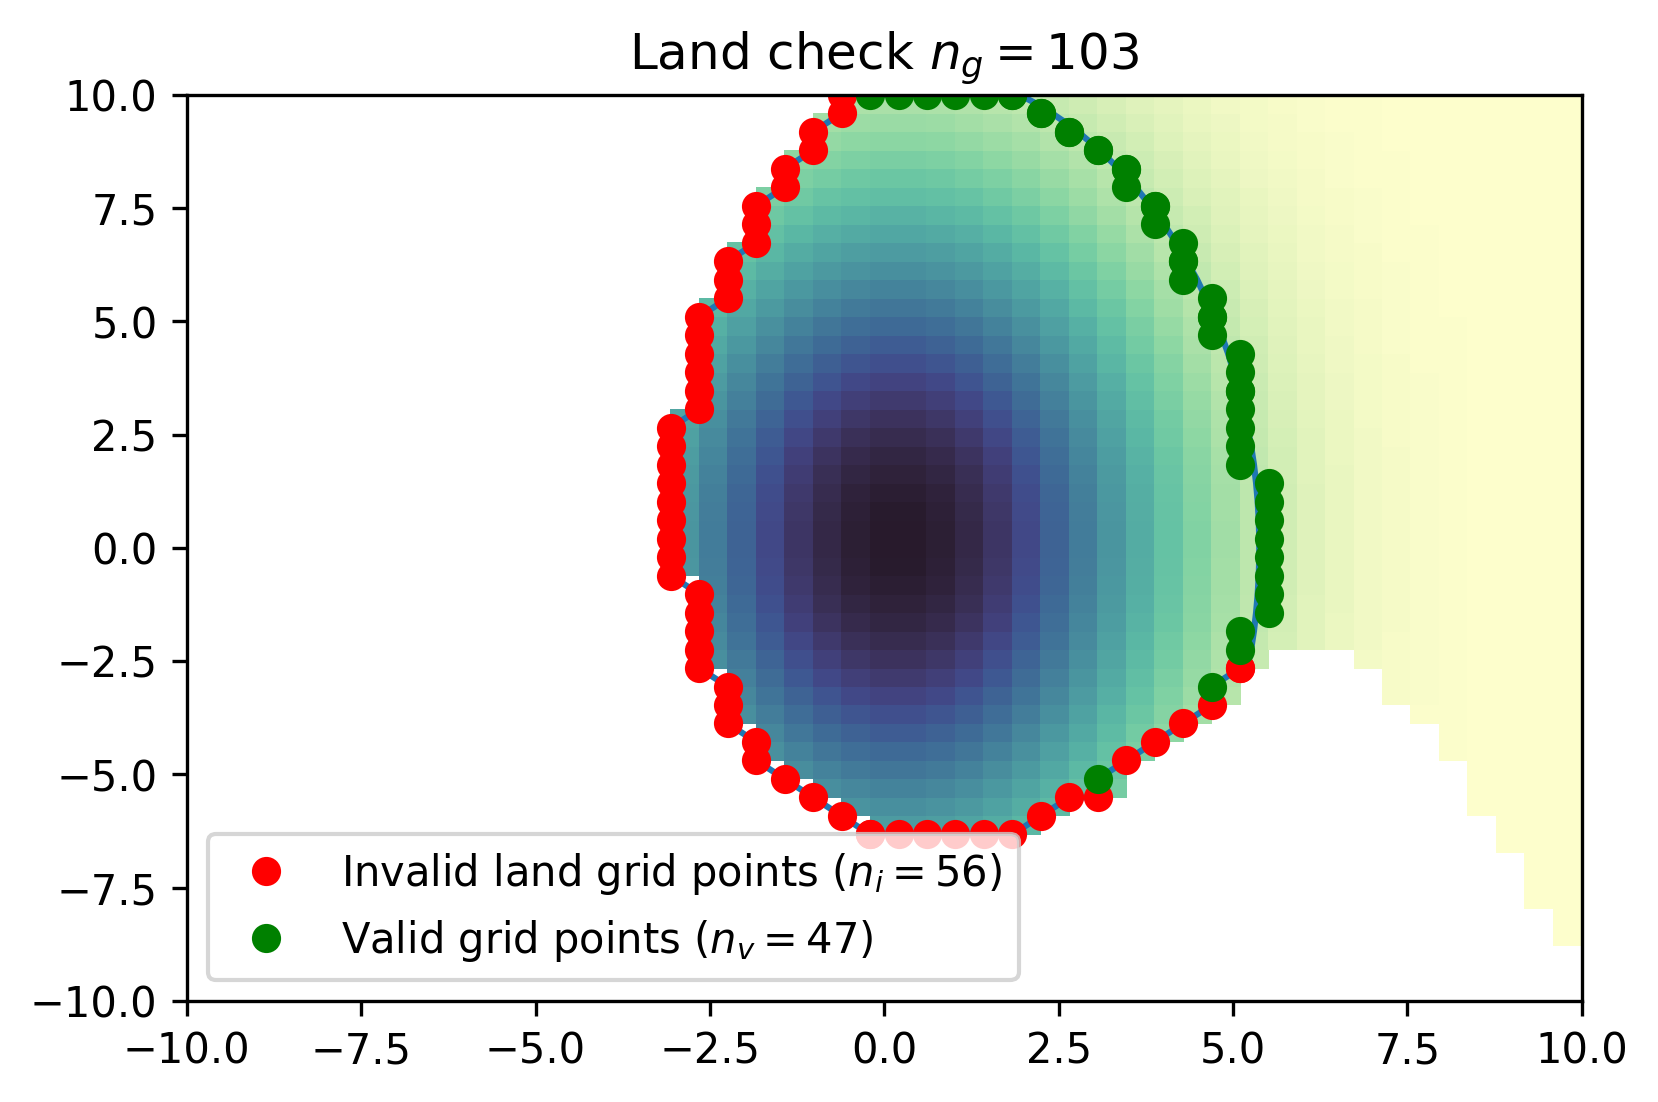

In [600]:
a=array([cs.allsegs[0][0][:,0],cs.allsegs[0][0][:,1]]).T
landcheck=eddylandcheck(a,x,y,zzmask,[True])